In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import nivapy
import imp
import pandas as pd
import os
plt.style.use('ggplot')

# NOPE runs for the MARTINI project

Based on a brief chat with André on 24/01/2018, for the MARTINI project we need to run the NOPE model for 2012 to 2016 inclusive. This is done here.

**NOTE:** NOPE is not yet fully tested - use these results with caution! For comparison, I will also provide load estimates based on the monthly measured data in the 11 main RID rivers.

## 1. Connect to NIVABASE

In [2]:
# Connect to NIVABASE
ora_eng = nivapy.da.connect(src='nivabase')

Username: ········
Password: ········
Connection successful.


## 2. Load NOPE

In [3]:
# Import NOPE model
nope_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\Python\rid\notebooks\nope.py')
nope = imp.load_source('nope', nope_path)

## 3. User input

In [4]:
# Period of interest
st_yr, end_yr = 1990, 2016

# Parameters of interest
par_list = ['Tot-N', 'Tot-P']

# Folder containing core NOPE data
nope_fold = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
             r'\NOPE\NOPE_Core_Input_Data')

# Folder for annual NOPE data
ann_fold = (r'C:\Data\James_Work\Staff\Phil_W\MARTINI\NOPE'
            r'\NOPE_Annual_Inputs_2012-2016')

# Folder for NOPE results file
res_fold = (r'C:\Data\James_Work\Staff\Phil_W\MARTINI\NOPE'
            r'\NOPE_Results_2012-2016')

## 4. Generate model input files from the NIVABASE

In [5]:
# Loop over years
for year in range(st_yr, end_yr+1):
    # Make input file
    ann_csv = os.path.join(ann_fold, 'nope_input_data_%s.csv' % year)   
    df = nope.make_rid_input_file(year, ora_eng, nope_fold, ann_csv,
                                  par_list=par_list)

No spredt data for 1990.
No renseanlegg data for 1990.
No spredt data for 1991.
No aquaculture data for 1991.
No renseanlegg data for 1991.
No spredt data for 1992.
No renseanlegg data for 1992.


C:\Data\Anaconda2\lib\site-packages\pandas\core\frame.py:3790: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  downcast=downcast, **kwargs)


## 5. Run model

In [6]:
# List of all main catchment IDs
cat_ids = ['%03d.' % i for i in range(1, 316)]

# Container for output
df_list = []

# Loop over years
for year in range(st_yr, end_yr+1):
    # Run model
    ann_csv = os.path.join(ann_fold, 'nope_input_data_%s.csv' % year) 
    g = nope.run_nope(ann_csv, par_list)
    
    # Save full NOPE results
    res_csv = os.path.join(res_fold, 'nope_results_%s.csv' % year)
    df = nope.model_to_dataframe(g, out_path=res_csv)

    # Filter to main catchments only
    df_filt = df[df['regine'].isin(cat_ids)]
    
    # Add year
    df_filt['year'] = year
    
    # Get just total loads
    df_filt = df_filt[['regine',
                       'year',
                       'accum_all_sources_tot-n_tonnes',
                       'accum_all_sources_tot-p_tonnes']]
    
    # Add to output
    df_list.append(df_filt)

# Combine output
df_all = pd.concat(df_list, axis=0, sort=False)

# Tidy
df_all.rename({'regine':'vassomr'}, axis='columns', inplace=True)
    
# Save results
res_csv = os.path.join(res_fold, 'nope_results_main_cats_%s-%s.csv' % (st_yr, end_yr))
df_all.to_csv(res_csv, index=False, encoding='utf-8')

C:\Data\Anaconda2\lib\site-packages\ipykernel_launcher.py:21: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


## 6. Compare to observations

As a quick check, we can compare the output from NOPE to the monitored loads calculated for the RID programme. The code below is messy as it's taken directly from my [NOPE autocalibration notebook](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/calibrating_nope.ipynb), which attempts to do more than just compare modelled versus observed values. This code essentially sets up the model for MCMC-based autocalibration, but as a side effect it also generates dataframes of modelled versus observed values, which is all I'm interested in here.

In [7]:
# Read obs data
obs_df, cal_df, val_df = nope.read_obs_data(1)

# Build input dict
par_list_lo = [i.lower() for i in par_list]
in_data = nope.build_input_dict(st_yr, end_yr, par_list_lo)

# Get catch IDs with calib data
calib_nds = set(cal_df['nve_vassdrag_nr'].values)

# Pre-build network for speed
in_path = (r'C:\Data\James_Work\Staff\Oeyvind_K\Elveovervakingsprogrammet'
           r'\NOPE\NOPE_Annual_Inputs\nope_input_data_1990.csv')
g, nd_list = nope.build_calib_network(in_path, calib_nds)

# Run model with default TEOTIL params
df = nope.run_model_multi_year(g, nd_list, st_yr, end_yr, in_data, 
                               par_list_lo, calib_nds, cal_pars=None)

# Join results to obs data
df = pd.merge(obs_df, df, how='left',
              left_on=['nve_vassdrag_nr', 'year'],
              right_on=['regine', 'year'])

# Convert obs flow to m3/s
df['obs_q_m3/s'] = df['mean_q_1000m3/day']*1000/(24*60*60)
del df['mean_q_1000m3/day']

# Drop NaNs (obs_df contains data from 1990; 
# we're just interested in post-2012)
df.dropna(how='any', inplace=True)

df.head()

,station_id,year,obs_tot-p_tonnes,obs_tot-n_tonnes,nve_vassdrag_nr,rid_group,regine,q_m3/s,tot-n_tonnes,tot-p_tonnes,obs_q_m3/s
0,29615,1990,39.700336,1235.212106,015.A1,rid_11,015.A1,162.269632,1805.453806,27.549689,117.119821
1,29615,1991,33.353097,1105.169503,015.A1,rid_11,015.A1,121.824784,1555.189987,25.092207,91.260339
2,29615,1992,23.337892,1409.367745,015.A1,rid_11,015.A1,130.243022,1583.410979,24.792755,90.722083
3,29615,1993,52.173714,1586.323638,015.A1,rid_11,015.A1,152.674548,1768.018713,30.710944,114.207464
4,29615,1994,33.284365,1724.631323,015.A1,rid_11,015.A1,173.973088,1909.073868,31.541542,125.269546


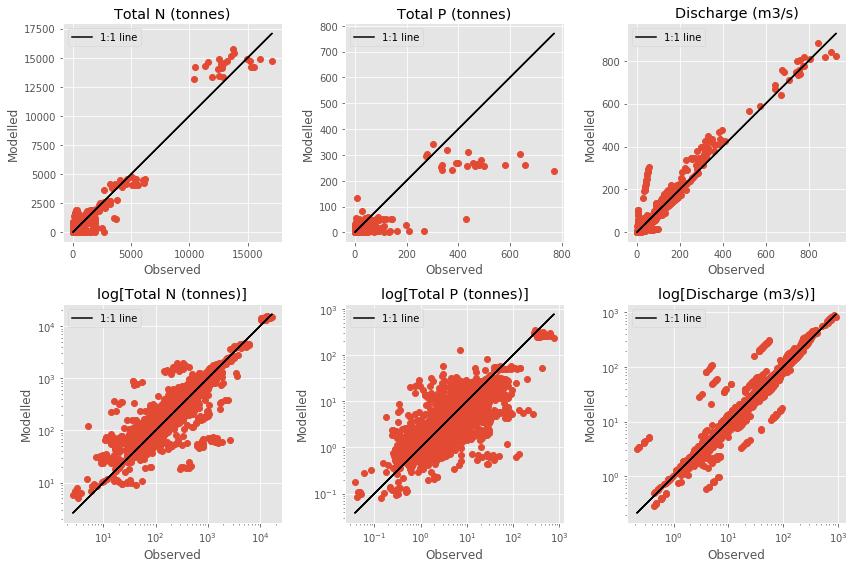

In [8]:
def plot_mod_obs(df):
    """ Simple plot to asses goodness-of-fit of model results.
    
    Args:
        df: Dataframe of modelled and observed values.
        
    Returns:
        None
    """
    # Plot
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(12,8))

    # Pairs to plot
    data_pairs = [('Total N (tonnes)', 'obs_tot-n_tonnes', 'tot-n_tonnes'),
                  ('Total P (tonnes)','obs_tot-p_tonnes', 'tot-p_tonnes'),
                  ('Discharge (m3/s)', 'obs_q_m3/s', 'q_m3/s')]

    # Loop over pairs
    for idx, item in enumerate(data_pairs):
        # Plot un-logged
        axes[0, idx].plot(df[item[1]], df[item[2]], 'o', label='')
        axes[0, idx].plot(df[item[1]], df[item[1]], 'k-', label='1:1 line')
        axes[0, idx].set_xlabel('Observed')
        axes[0, idx].set_ylabel('Modelled')
        axes[0, idx].set_title(item[0])
        axes[0, idx].legend(loc='upper left')

        # Plot logged
        axes[1, idx].plot(df[item[1]], df[item[2]], 'o', label='')
        axes[1, idx].plot(df[item[1]], df[item[1]], 'k-', label='1:1 line')
        axes[1, idx].set_xlabel('Observed')
        axes[1, idx].set_ylabel('Modelled')
        axes[1, idx].set_title('log[%s]' % item[0])
        axes[1, idx].legend(loc='upper left')
        axes[1, idx].set_xscale('log')
        axes[1, idx].set_yscale('log')

    plt.tight_layout()
    
    return None

# Plot results
plot_mod_obs(df)

The results using the default TEOTIL parameters aren't very good, especially for Total P. I've begun some further work to calibrate the model (see [here](http://nbviewer.jupyter.org/github/JamesSample/rid/blob/master/notebooks/calibrating_nope.ipynb)), but haven't had chance to make much progress recently.